# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 1min 31s, sys: 1.98 s, total: 1min 33s
Wall time: 1min 37s


Parse works cited section of the `README.md` document for more analysis information.

In [3]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [4]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,23
organization,20
article,37
codes,158
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [6]:
codingOrder = pd.DataFrame({'article': [
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [7]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0
#codesByArticle['cumulative codeset'] = None

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,13,california-ccscore-analysis,"[format table display, read as tabular data, d...",0,23,"drop entirely duplicate rows, read as tabular ..."
1,6,2019-04-democratic-candidate-codonors,"[use public data, read as tabular data, archit...",1,42,"use public data, union tables, sum column valu..."
2,14,california-crop-production-wages-analysis,"[use public data, format table display, constr...",3,45,"adjust for inflation, construct table manually..."
3,16,census-hard-to-map-analysis,"[wrangle data for graphics, use public data, c...",4,47,"wrangle data for graphics, slice column values"
4,25,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,56,"perform name entity resolution manually, join ..."


Plot the size of the code set as more computational notebooks are analyzed.

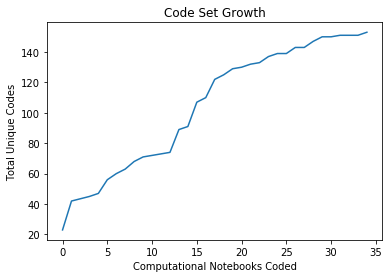

In [8]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [ ]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: drop entirely duplicate rows, read as tabular data, group by single column, calculate percentage difference, calculate mean, drop columns, count value frequency, filter rows, plot histogram, export results, calculate z-score, adjust for season, repetitive code, change column data type, format table display, count number of records, inspect table schema, remove incomplete data, calculate difference, inner join tables, sort table, split, compute, and merge, peek at data

2. **2019-04-democratic-candidate-codonors**: use public data, union tables, sum column values, remove with regular expression, outer join tables, export intermediate results, create a semi-unique key, gather table, calculate scaled ratio, group by multiple columns, annotate workflow, canonicalize column names, calculate ratio, count unique values in column, prevent double-counting, architect a subroutine, strip whitespace, change case, self join table

3. **california-crop-production-wages-analysis**: adjust for inflation, construct table manually, architect repeating process

4. **census-hard-to-map-analysis**: wrangle data for graphics, slice column values

5. **long-term-care-db**: perform name entity resolution manually, join with lookup table, encode table identification in row, scrape web for data, drop erroneous rows, construct pivot table, drop rows with duplicate value in one column, fix data errors manually, use non-public, provided data

6. **2018-voter-registration**: extract single value, plot stacked column chart, pull tables out of pdf, plot stacked bar chart

7. **heat_and_humidity**: compute index number, cartesian product, generate data computationally

8. **2016-11-bellwether-counties**: create rolling window, spread table, get max value, calculate spread, use academic data

9. **2018-05-31-crime-and-heat-analysis**: plot scatterplot, combine seemingly disparate datasets, extract property from datetime

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: calculate using an external data structure

12. **2016-04-republican-donor-movements**: split column on delimiter

13. **california-h2a-visas-analysis**: replace na values, cache results from external service, trim by geographic area, preserve existing values, geocode addresses, temporary joining column, encoding provenance in data, omits data quality exploration, plot column chart, trim by date range, create a crosstab, remove all rows but the master record, display entire table, create a unique key, split and compute

14. **Endangered-Species-Act-Louisiana**: perform scalar multiplication, plot trendline

15. **Power_of_Irma**: use previously cleaned data, find most frequently occurring, plot boxplot, select columns, toggle step on and off, plot violin plot, value replacement, fit a generalized linear model, find worst offender, tolerate dirty data, set data confidence threshold, use data from colleague, change date format, look for trends, log-ify values, fix incorrect calculation

16. **wikipedia-rankings**: plot scree plot, collect raw data, analyze principle components

17. **babyname_politics**: check results of previous operation, peel and merge, data loss from aggregation, natural join, join aggregate, get unique values, concatenate columns into key, trim by quantitative threshold, resort after merge, round floating point, break ties, assign ranks

18. **2015-11-refugees-in-the-united-states**: compare total number of rows, make an incorrect conclusion, designate column as primary key

19. **employment-discrimination**: combine entities by string matching, merge tables to create pivot table, concatenate files together, align table columns for consolidation

20. **bechdel**: calculate median

21. **bob-ross**: run cluster analysis, whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: test for equality, translate entity names manually, data too large for repo, create flag

24. **buster-posey-mvp**: plot line chart, image analysis

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: remove delimiting characters, filter by contains value, sort table rows, report rows with column number discrepancies

27. **prison-admissions**: 

28. **school-star-ratings-2018**: pad column values, get min value, reconcile primary keys between tables, display rows with errors

29. **electric-car-charging-points**: define edge weights, add foreign key column, encode redundant information

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices, create a table to lookup values